<a href="https://colab.research.google.com/github/Vaibhav-S75/Team_404_Object_Detection/blob/main/improved_accuracy25k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive and Install Required Libraries
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow keras opencv-python-headless matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Import Necessary Libraries
import os
import cv2
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
import logging

# Suppress warnings for invalid category_ids
logging.getLogger().setLevel(logging.ERROR)

# Step 3: Define Paths and Load Annotations
image_folder = '/content/drive/MyDrive/coco_data_set/train2014/train2014'
annotations_path = '/content/drive/MyDrive/coco_data_set/annotations/annotations/instances_train2014.json'

# Load COCO annotations
with open(annotations_path, 'r') as f:
    coco_annotations = json.load(f)

# Step 4: Create Annotations Dictionary with Filtering Invalid Category IDs
valid_category_ids = set(range(1, 81))  # Valid COCO category_ids are 1 to 80
annotations_dict = {}
for annotation in coco_annotations['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']

    # Check if the category_id is valid, silently ignore invalid category_id
    if category_id in valid_category_ids:
        if image_id not in annotations_dict:
            annotations_dict[image_id] = []
        annotations_dict[image_id].append(annotation)



In [ ]:
# # len(os.listdir(image_folder))
# from tqdm import tqdm
# missing_image_ids = [519138, 135420, 61830, 431980, 371598, 337844, 177109, 532482, 77693, 510622]  # Add all missing IDs

# all_files = [ ]
# for i in tqdm(os.listdir(image_folder)):
#   if i not in missing_image_ids:
#     all_files.append(i)
# print(len(all_files))

In [ ]:
# len(all_files)

In [ ]:
# Step 5: List Image Files and Filter
all_files = [img for img in os.listdir(image_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
missing_image_ids = [519138, 135420, 61830, 431980, 371598, 337844, 177109, 532482, 77693, 510622]  # Add all missing IDs

existing_images = []
image_ids = []
for image in all_files[:25000]:  # Using the first 25,000 images
    try:
        image_id = int(image.split('_')[-1].split('.')[0])
        if image_id not in missing_image_ids:
            existing_images.append(image)
            image_ids.append(image_id)
    except ValueError:
        print(f"Skipping file '{image}' due to ValueError.")

print(f"Total existing images after filtering: {len(existing_images)}")

# Step 6: Preprocess Images Function
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = image / 255.0  # Normalize to [0, 1]
        return image
    except Exception as e:
        # Suppress error messages and skip problematic images
        return None

# Step 7: Data Generator for Memory-Efficient Loading
def data_generator(image_paths, image_ids, annotations_dict):
    num_samples = len(image_paths)
    X = []
    Y = []
    count = 0
    for img_path, img_id in zip(image_paths, image_ids):
        if count % 100 == 0:
          print(f"{count +1 }/{len(image_ids)}")
        count += 1
        img = preprocess_image(os.path.join(image_folder, img_path))
        # print(count)
        if img is not None:
            X.append(img.numpy())
            labels = [0] * 80  # COCO has 80 classes
            if img_id in annotations_dict:
                for anno in annotations_dict[img_id]:
                    category_id = anno['category_id']
                    # Only set labels for valid category IDs
                    if category_id in valid_category_ids:
                        labels[category_id - 1] = 1  # Set category label
            Y.append(labels)
    return np.array(X), np.array(Y)
# Step 8: Split Dataset into Training and Validation Sets
train_images, val_images, train_ids, val_ids = train_test_split(existing_images, image_ids, test_size=0.2, random_state=42)



Total existing images after filtering: 25000


In [ ]:
batch_size = 100
train_X, train_Y = data_generator(train_images, train_ids, annotations_dict)
val_X, val_Y = data_generator(val_images, val_ids, annotations_dict)

1/20000
101/20000
201/20000
301/20000
401/20000
501/20000
601/20000
701/20000
801/20000
901/20000
1001/20000
1101/20000
1201/20000
1301/20000
1401/20000
1501/20000
1601/20000
1701/20000
1801/20000
1901/20000
2001/20000
2101/20000
2201/20000
2301/20000
2401/20000
2501/20000
2601/20000
2701/20000
2801/20000
2901/20000
3001/20000
3101/20000
3201/20000
3301/20000
3401/20000
3501/20000
3601/20000
3701/20000
3801/20000
3901/20000
4001/20000
4101/20000
4201/20000
4301/20000
4401/20000
4501/20000
4601/20000
4701/20000
4801/20000
4901/20000
5001/20000
5101/20000
5201/20000
5301/20000
5401/20000
5501/20000
5601/20000
5701/20000
5801/20000
5901/20000
6001/20000
6101/20000
6201/20000
6301/20000
6401/20000
6501/20000
6601/20000
6701/20000
6801/20000
6901/20000
7001/20000
7101/20000
7201/20000
7301/20000
7401/20000
7501/20000
7601/20000
7701/20000
7801/20000
7901/20000
8001/20000
8101/20000
8201/20000
8301/20000
8401/20000
8501/20000
8601/20000
8701/20000
8801/20000
8901/20000
9001/20000
9101/20000


In [ ]:
# next(iter(train_data))

In [ ]:
# Step 9: Define the CNN Model
def create_cnn_model(input_shape, num_classes=80):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),  # Add dropout to prevent overfitting
        layers.Dense(num_classes, activation='sigmoid')  # Use sigmoid for multi-label classification
        # layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Step 10: Compile the Model
model = create_cnn_model((128, 128, 3))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0395 - loss: 0.5268 - val_accuracy: 0.2375 - val_loss: 0.1711
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.1554 - loss: 0.2111 - val_accuracy: 0.7500 - val_loss: 0.1430
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4039 - loss: 0.1694 - val_accuracy: 0.7500 - val_loss: 0.1504
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3110 - loss: 0.1673 - val_accuracy: 0.6438 - val_loss: 0.1380
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3694 - loss: 0.1534 - val_accuracy: 0.7500 - val_loss: 0.1370
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4082 - loss: 0.1510 - val_accuracy: 0.7500 - val_loss: 0.1329
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3145 - loss: 0.1468 - val_accuracy: 0.7500 - val_loss: 0.1338
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3711 - loss: 0.1458 - val_accuracy: 0.7500 - val_loss: 0.

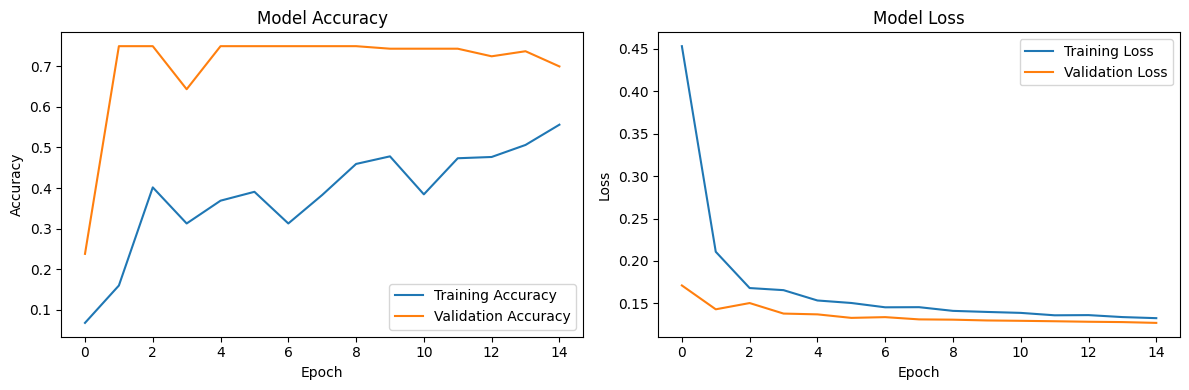

8555

In [ ]:
history = model.fit(
    x=train_X,
    y=train_Y,
    epochs=15,
    validation_split=0.2,
    batch_size=256,
    verbose=1,
    # validation_data=data_generator(val_images, val_ids, annotations_dict, batch_size),
    # validation_steps=validation_steps
)

# Step 12: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_X,val_Y,batch_size=256)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

# Step 13: Save the Model
model.save('object_detection_model_25k_images.keras')

# Step 14: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 15: Clear Memory After Training
del model, history
gc.collect()
